# Прогноз оттокa клиентов для оператора связи

### Описание проекта

Нам необходимо **спрогнозировать отток клиентов** для оператора связи.

Пользователям которые планирует уйти, будут предложены промокоды и специальные условия. 

Заказчик предоставил датасеты с персональными данными о некоторых клиентах, информацию об их тарифах и договорах.

### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

Описание исходных признаков данных:
* **BeginDate** - дата начала пользования услугами,
* **EndDate** - дата окончания пользования услугами,
* **Туре** - тип оплаты: ежемесячный, годовой и тд,
* **PaperlessBilling** - электронный платёжный документ,
* **PaymentMethod** - способ оплаты,
* **MonthlyCharges** - ежемесячные траты на услуги,
* **TotalCharges** - всего потрачено денег на услуги
* **Dependents** - наличие иждивенцев
* **Senior Citizen** - наличие пенсионного статуса по возрасту
* **Partner** - наличие супруга(и)
* **MultipleLines** - наличие возможности ведения параллельных линий во время звонка

### План работ

1. Подготовка данных
    * 1.1. Откроем файлы и изучим их.
    * 1.2. Проверим типы данных, есть ли пропуски, надо ли преобразовывать данные
    * 1.3. Проанализируем признаки на предмет значимости
    * 1.4. Определим целевой признак
    * 1.5. Выводы
2. Исследовательский анализ данных
    * 2.1. Построим гистограммы и оценим распределение числовых признаков
    * 2.2. Построим графики и проверим наличие выбросов
    * 2.3. Выводы
3. Построение моделей 
    * 3.1. Подготовим выборки 
    * 3.2. Выберем несколько моделей и подготовим пайпалайн 
    * 3.3. Обучим разные модели и оценим их качество кросс-валидацией. 
    * 3.4. Выберем лучшую модель и проверим её на тестовой выборке.
    * 3.5. Выводы
4. Итоговы выводы по проекту



### 1. Подготовка данных

In [1]:
import pandas as pd
import numpy as np 

import os
from types import SimpleNamespace

import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from numpy.random import RandomState

from sklearn.model_selection import (GridSearchCV,
                                     KFold,
                                     train_test_split)

from sklearn.preprocessing import (StandardScaler,
                                   OrdinalEncoder,
                                   OneHotEncoder)


from catboost import CatBoostClassifier, Pool
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score

from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report


In [2]:
#объявим константы
#зафиксируме рандом стейт
RANDOM_STATE = 270223

#пропишем путь к исходным файлам
DATA_FOLDER_YANDEX = '/datasets/final_provider'
DATA_FOLDER_LOCAL = 'final_provider'

In [3]:
#загрузим данные и выведем sample
data_folder = DATA_FOLDER_YANDEX if os.path.exists (DATA_FOLDER_YANDEX) \
                                 else DATA_FOLDER_LOCAL

data = SimpleNamespace()
for file_name in os.listdir(data_folder):
    if os.path.isfile(os.path.join(data_folder, file_name)):
        setattr(data, 
                file_name.split('.')[0],
                pd.read_csv(os.path.join(data_folder, file_name))
                )

data.contract.name = 'contract'
data.internet.name = 'internet'
data.personal.name = 'personal'
data.phone.name = 'phone'


#проверка
display(data.contract.sample(5))
display(data.internet.sample(5))
display(data.personal.sample(5))
display(data.phone.sample(5))

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
2716,7883-ROJOC,2018-07-01,No,Month-to-month,No,Mailed check,44.90,839.65
2461,7706-YLMQA,2014-04-01,No,One year,No,Bank transfer (automatic),19.70,1341.5
6539,5949-HGVJL,2017-12-01,No,Month-to-month,Yes,Electronic check,73.05,1959.5
597,5172-MIGPM,2019-10-01,No,Month-to-month,No,Mailed check,65.55,237.2
5613,3913-FCUUW,2014-02-01,No,Two year,Yes,Bank transfer (automatic),70.45,5165.7


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
3049,8015-IHCGW,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes
5233,8080-POTJR,DSL,Yes,No,Yes,No,Yes,Yes
4148,6078-VESFR,Fiber optic,No,No,No,No,No,No
3813,5304-EFJLP,Fiber optic,No,Yes,Yes,Yes,Yes,Yes
2868,7826-VVKWT,Fiber optic,No,No,Yes,No,Yes,Yes


,customerID,gender,SeniorCitizen,Partner,Dependents
2182,2530-FMFXO,Male,0,Yes,Yes
3259,9620-ENEJV,Female,0,No,No
2156,2737-YNGYW,Female,0,No,No
3894,5989-AXPUC,Female,0,Yes,No
6579,3938-YFPXD,Male,0,No,No


,customerID,MultipleLines
5157,4475-NVTLU,No
2306,0784-ZQJZX,No
1812,7710-JSYOA,Yes
165,5524-KHNJP,No
2677,5312-IRCFR,Yes


In [4]:
#создадим список исходных данных для работы
data.data_names = [data.contract, data.internet, data.personal, data.phone] 

In [5]:
for item in data.data_names:
    print("Датасет:", item.name)
    display(item.sample())
    display(item.info())
    print("--------------------------------")

Датасет: contract


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
5496,2208-NKVVH,2016-07-01,No,Two year,No,Mailed check,24.25,1077.95


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

--------------------------------
Датасет: internet


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
3473,6161-UUUTA,Fiber optic,No,No,No,No,Yes,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

--------------------------------
Датасет: personal


,customerID,gender,SeniorCitizen,Partner,Dependents
2268,7205-BAIAD,Female,0,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

--------------------------------
Датасет: phone


,customerID,MultipleLines
3219,5062-CJJKH,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

--------------------------------


### Выводы по блоку 1: 
* Все четыре датасета не содержат пропущенных значений. 

* В датасетах contract и personal 7043 записей, в internet и phone - 5517 и 6361 соотвтетственно. Вероятнее всего это связано с тем, что не все пользователи заключили контракт на пользование интеренетом и телефонией. 

* В дальнейшем при объединении датасетов обратим внимание на общее количество записей.

* Целевой признак явным образом не выделен в датасете, но обратим внимание, на признаки BeginDate и EndDate, в признаке EndDate указано "No" - на основании этих данных выделим целевой признак в следующем пункте. 

* В данном проекте мы решаем задачу бинарной классификации поэтому после выделения целевого признака будет целесообразно избивиться от признаков BeginDate и EndDate, чтобы не "сбивать с толку" модель. 

* Чтобы не терять информацию из признаков BeginDate и EndDate, создадим на основе них признак DaysUsed - в который запишем разницу EndDate и BeginDate 

* Все категориальные переменные необходимо будет закодировать и после применить скейлер. 

Необходимо изменить тип данных для признаков датасета **contract**: 
* **BeginDate**, **EndDate** на *datetime*, 
* **TotalCharges** на *float64*

Вероятнее всего так как данные признаки имеют тип данныз object - в них есть значения заглушки, изучим эти признаки подробнее на следующем этапе. 

In [6]:
#приведем названия признаков к единому стилю
for item in data.data_names:
    item.rename(columns={'customerID': 'CustomerID'}, inplace=True)

data.personal.rename(columns={'gender': 'Gender'}, inplace=True)

In [7]:
#Добавим целевой признак, если контракт закрыт и EndDate не равно "No", то проставляем 1, в противном случае 0
data.contract['Churn'] = (data.contract['EndDate'] != 'No').astype(int)
data.contract.sample(5)

,CustomerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
5239,2056-EVGZL,2014-06-01,No,One year,No,Credit card (automatic),105.75,7322.5,0
3200,0895-DQHEW,2015-06-01,2019-12-01 00:00:00,Month-to-month,Yes,Electronic check,104.30,5278.15,1
637,2077-DDHJK,2014-06-01,No,Two year,No,Credit card (automatic),70.90,4911.35,0
929,8812-ZRHFP,2017-08-01,No,One year,No,Electronic check,86.45,2538.05,0
5655,5666-MBJPT,2014-09-01,No,Two year,Yes,Bank transfer (automatic),25.10,1725,0


In [8]:
# Создадим признак DaysUsed, для этого заменим значения "No" в столбце EndDate на дату выгрузки датасета и найдем разницу между EndDate и BeginDate
data.contract['EndDate'] = data.contract['EndDate'].replace(['No'], ['2020-02-01'])

#приведем даты к единому формату
data.contract['BeginDate'] = pd.to_datetime(data.contract['BeginDate'], format='%Y-%m-%d')
data.contract['EndDate'] = pd.to_datetime(data.contract['EndDate'], format='%Y-%m-%d')

data.contract['DaysUsed'] = (data.contract['EndDate'] - data.contract['BeginDate']).dt.days

display(data.contract.sample(5))
display(data.contract.info())

,CustomerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,DaysUsed
3068,1810-BOHSY,2015-11-01,2020-02-01,One year,Yes,Credit card (automatic),96.40,4911.05,0,1553
1435,9052-VKDUW,2014-09-01,2020-02-01,Month-to-month,Yes,Credit card (automatic),109.40,7227.45,0,1979
472,1304-BCCFO,2019-05-01,2020-02-01,Month-to-month,Yes,Mailed check,70.05,564.4,0,276
1237,2788-CJQAQ,2019-01-01,2020-02-01,One year,No,Mailed check,19.45,270.2,0,396
3402,4951-UKAAQ,2019-07-01,2019-11-01,Month-to-month,Yes,Electronic check,88.95,355.2,1,123


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   CustomerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   object        
 8   Churn             7043 non-null   int64         
 9   DaysUsed          7043 non-null   int64         
dtypes: datetime64[ns](2), float64(1), int64(2), object(5)
memory usage: 550.4+ KB


None

In [9]:
data.contract['TotalCharges'] = pd.to_numeric(data.contract['TotalCharges'], errors ='coerce')
data.contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   CustomerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   Churn             7043 non-null   int64         
 9   DaysUsed          7043 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(2), object(4)
memory usage: 550.4+ KB


In [10]:
#можем заметить, что в признаке TotalCharges появились пустые значения
data.contract[data.contract['TotalCharges'].isnull()]

,CustomerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,DaysUsed
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,NaN,0,0
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,NaN,0,0
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,NaN,0,0
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,NaN,0,0
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,NaN,0,0
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,NaN,0,0
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,NaN,0,0
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,NaN,0,0
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,NaN,0,0
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,NaN,0,0


Даты признаков BeginDate и EndDate совпадают - это новые клиенты которым еще не выставлены счета за услуги DaysUsed = 0. 

Такие данные с большой долей вероятности не репрезентативны и скорее всего окажутся в числе выбросов, удалим их, тем более что это всего 11 записей из 7 тыс. 

In [11]:
data.contract = data.contract[~data.contract['TotalCharges'].isnull()]
data.contract.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   CustomerID        7032 non-null   object        
 1   BeginDate         7032 non-null   datetime64[ns]
 2   EndDate           7032 non-null   datetime64[ns]
 3   Type              7032 non-null   object        
 4   PaperlessBilling  7032 non-null   object        
 5   PaymentMethod     7032 non-null   object        
 6   MonthlyCharges    7032 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   Churn             7032 non-null   int64         
 9   DaysUsed          7032 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(2), object(4)
memory usage: 604.3+ KB


In [12]:
# чтобы не потерять важные данные при объединении датасетов, добавим в таблицы internet и phone соответствующие признаки
data.internet['InternetPlan'] = 'Yes'
data.phone['PhonePlan'] = 'Yes'

In [13]:
#после того как мы выделили признак DaysUsed и целевой признак Churn, можем удалить BeginDate и EndDate
data.contract.drop(['BeginDate', 'EndDate'], axis=1, inplace=True)

/var/folders/vw/2gwb12916v7g6sv898z3qx4r0000gn/T/ipykernel_66297/847758410.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.contract.drop(['BeginDate', 'EndDate'], axis=1, inplace=True)


In [14]:
#соберем данные в единый датафрейм
df = data.contract.merge(right=data.personal, on='CustomerID', validate='one_to_one')
df = df.merge(right=data.internet, how='left', on='CustomerID')
df = df.merge(right=data.phone, how='left', on='CustomerID')

#Установим CustomerID в качестве индекса
df = df.set_index('CustomerID')

display(df.sample(4))
display(df.info())

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,DaysUsed,Gender,SeniorCitizen,Partner,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,InternetPlan,MultipleLines,PhonePlan
CustomerID,,,,,,,,,,,,,,,,,,,,,
2097-YVPKN,Two year,No,Mailed check,25.75,1654.75,0,1979,Male,0,No,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,Yes
6766-HFKLA,Two year,No,Bank transfer (automatic),103.20,5744.35,0,1706,Female,0,Yes,...,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes
7826-VVKWT,Two year,Yes,Electronic check,96.55,2263.45,0,730,Female,1,Yes,...,Fiber optic,No,No,Yes,No,Yes,Yes,Yes,No,Yes
8930-XOTDP,Month-to-month,No,Mailed check,55.95,1082.80,0,549,Female,0,Yes,...,DSL,No,No,No,No,Yes,No,Yes,No,Yes


<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7032 non-null   object 
 1   PaperlessBilling  7032 non-null   object 
 2   PaymentMethod     7032 non-null   object 
 3   MonthlyCharges    7032 non-null   float64
 4   TotalCharges      7032 non-null   float64
 5   Churn             7032 non-null   int64  
 6   DaysUsed          7032 non-null   int64  
 7   Gender            7032 non-null   object 
 8   SeniorCitizen     7032 non-null   int64  
 9   Partner           7032 non-null   object 
 10  Dependents        7032 non-null   object 
 11  InternetService   5512 non-null   object 
 12  OnlineSecurity    5512 non-null   object 
 13  OnlineBackup      5512 non-null   object 
 14  DeviceProtection  5512 non-null   object 
 15  TechSupport       5512 non-null   object 
 16  StreamingTV       5512 non-null 

None

После объединения датасетов появились пропуски, так как в исходных датасетах было разное количество записей, вероятнее всего это обусловлено тем, что контракты на телефон и интернет заключаются поотдельности

In [15]:
#заполним пропуски значениями "No"
for column in ('InternetService', 
               'OnlineSecurity', 
               'OnlineBackup', 
               'DeviceProtection', 
               'TechSupport', 
               'StreamingTV', 
               'StreamingMovies', 
               'MultipleLines',
               'InternetPlan',
               'PhonePlan'):
    df[column] = df[column].fillna('No')

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7032 non-null   object 
 1   PaperlessBilling  7032 non-null   object 
 2   PaymentMethod     7032 non-null   object 
 3   MonthlyCharges    7032 non-null   float64
 4   TotalCharges      7032 non-null   float64
 5   Churn             7032 non-null   int64  
 6   DaysUsed          7032 non-null   int64  
 7   Gender            7032 non-null   object 
 8   SeniorCitizen     7032 non-null   int64  
 9   Partner           7032 non-null   object 
 10  Dependents        7032 non-null   object 
 11  InternetService   7032 non-null   object 
 12  OnlineSecurity    7032 non-null   object 
 13  OnlineBackup      7032 non-null   object 
 14  DeviceProtection  7032 non-null   object 
 15  TechSupport       7032 non-null   object 
 16  StreamingTV       7032 non-null 

In [16]:
#для посоедующей работы разделим признаки на численные и категориальные
numerical = df.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64'])
categorical = df.select_dtypes(include=['object'])

### 2. Исследовательский анализ данных

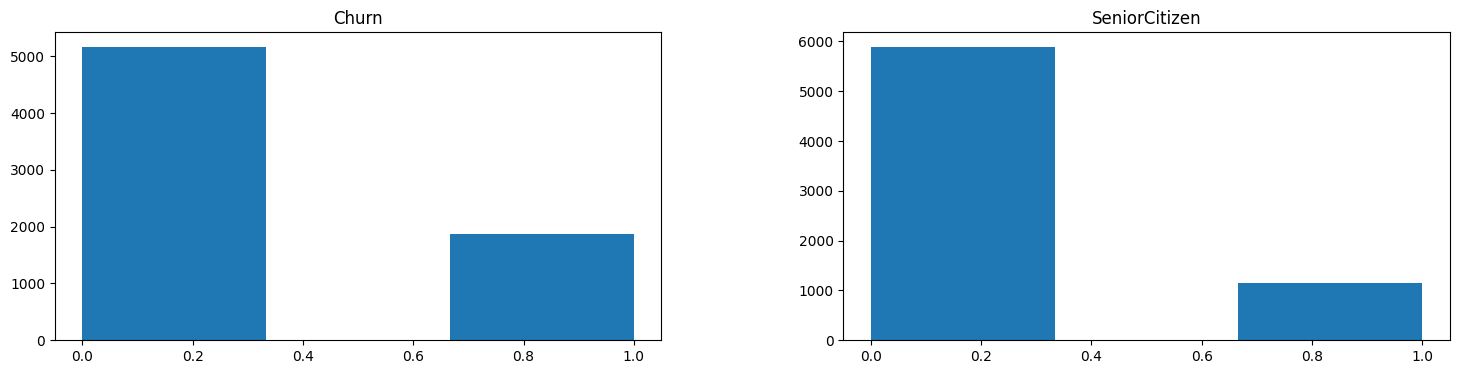

In [17]:
df.hist(column=['Churn', 'SeniorCitizen'], figsize=(18,4), grid=False, bins=3);

* Churn - подавляющее большинство пользователей лояльны
* присутствует дисбаланс классов в целевом признаке - необходимо будет это учесть при построении модели class_weight=balanced 
* SeniorCitizen - преобладающая доля клиентов это молодые люди не пенсионного возраста

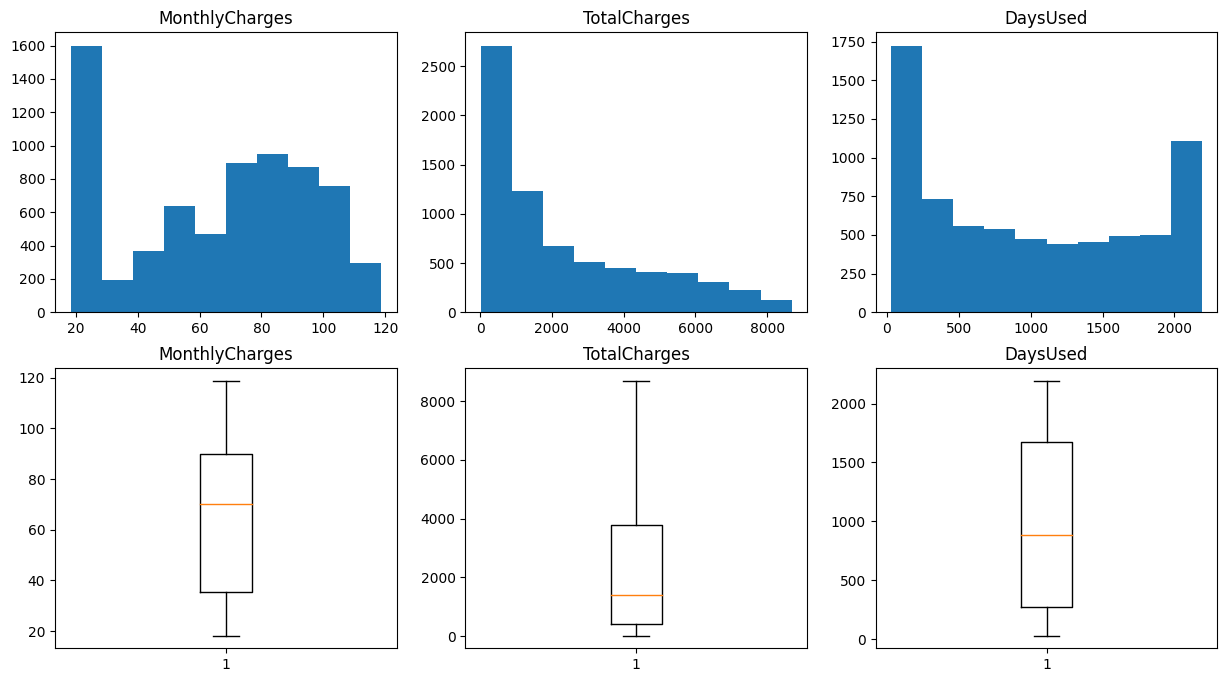

,MonthlyCharges,TotalCharges,DaysUsed
count,7032.000000,7032.000000,7032.000000
mean,64.798208,2283.300441,987.538538
std,30.085974,2266.771362,747.153663
min,18.250000,18.800000,30.000000
25%,35.587500,401.450000,275.000000
50%,70.350000,1397.475000,883.000000
75%,89.862500,3794.737500,1676.000000
max,118.750000,8684.800000,2191.000000


In [18]:
cols = 3
rows = 2

plt.figure(figsize=(15, 8))

idx = 0
for column in ['MonthlyCharges','TotalCharges', 'DaysUsed']:
    idx += 1 
    
    plt.subplot(rows, cols, idx)
    plt.hist(df[column])
    plt.title(column)
    
for column in ['MonthlyCharges','TotalCharges', 'DaysUsed']:
    idx += 1 
    
    plt.subplot(rows, cols, idx)
    plt.boxplot(df[column])
    plt.title(column)
        
plt.show()

display(df[['MonthlyCharges','TotalCharges', 'DaysUsed']].describe())

На основе графиков можно сделать следующие выводы:
* MonthlyCharges - можем заметить большое количество значений меньше 30, рассмотрим их отдельно
* DaysUsed - можно выделить две категории пользователей, те кто заключил договор недавно и те кто уже давно пользуется услугами
* TotalCharges - значения убывают, то есть пользователей которые пользуются базовыми тарифами и платят мало гораздо больше

In [19]:
df.query('MonthlyCharges < 25').sample(5)

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,DaysUsed,Gender,SeniorCitizen,Partner,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,InternetPlan,MultipleLines,PhonePlan
CustomerID,,,,,,,,,,,,,,,,,,,,,
3727-JEZTU,Month-to-month,No,Mailed check,20.40,20.4,0,31,Female,0,No,...,No,No,No,No,No,No,No,No,No,Yes
9800-OUIGR,Two year,No,Credit card (automatic),20.00,1374.2,0,2010,Male,0,Yes,...,No,No,No,No,No,No,No,No,No,Yes
1345-GKDZZ,Month-to-month,No,Mailed check,19.55,128.6,0,184,Male,0,No,...,No,No,No,No,No,No,No,No,No,Yes
6051-PTVNS,One year,No,Credit card (automatic),19.15,998.1,0,1676,Female,0,Yes,...,No,No,No,No,No,No,No,No,No,Yes
9986-BONCE,Month-to-month,No,Bank transfer (automatic),20.95,85.5,1,122,Female,0,No,...,No,No,No,No,No,No,No,No,No,Yes


Можем заметить, что в выборку MonthlyCharges < 25 попали базовые телефонные контракты (PhonePlan = Yes) без дополнительных опций и подключенного интернета (InternetPlan = No)

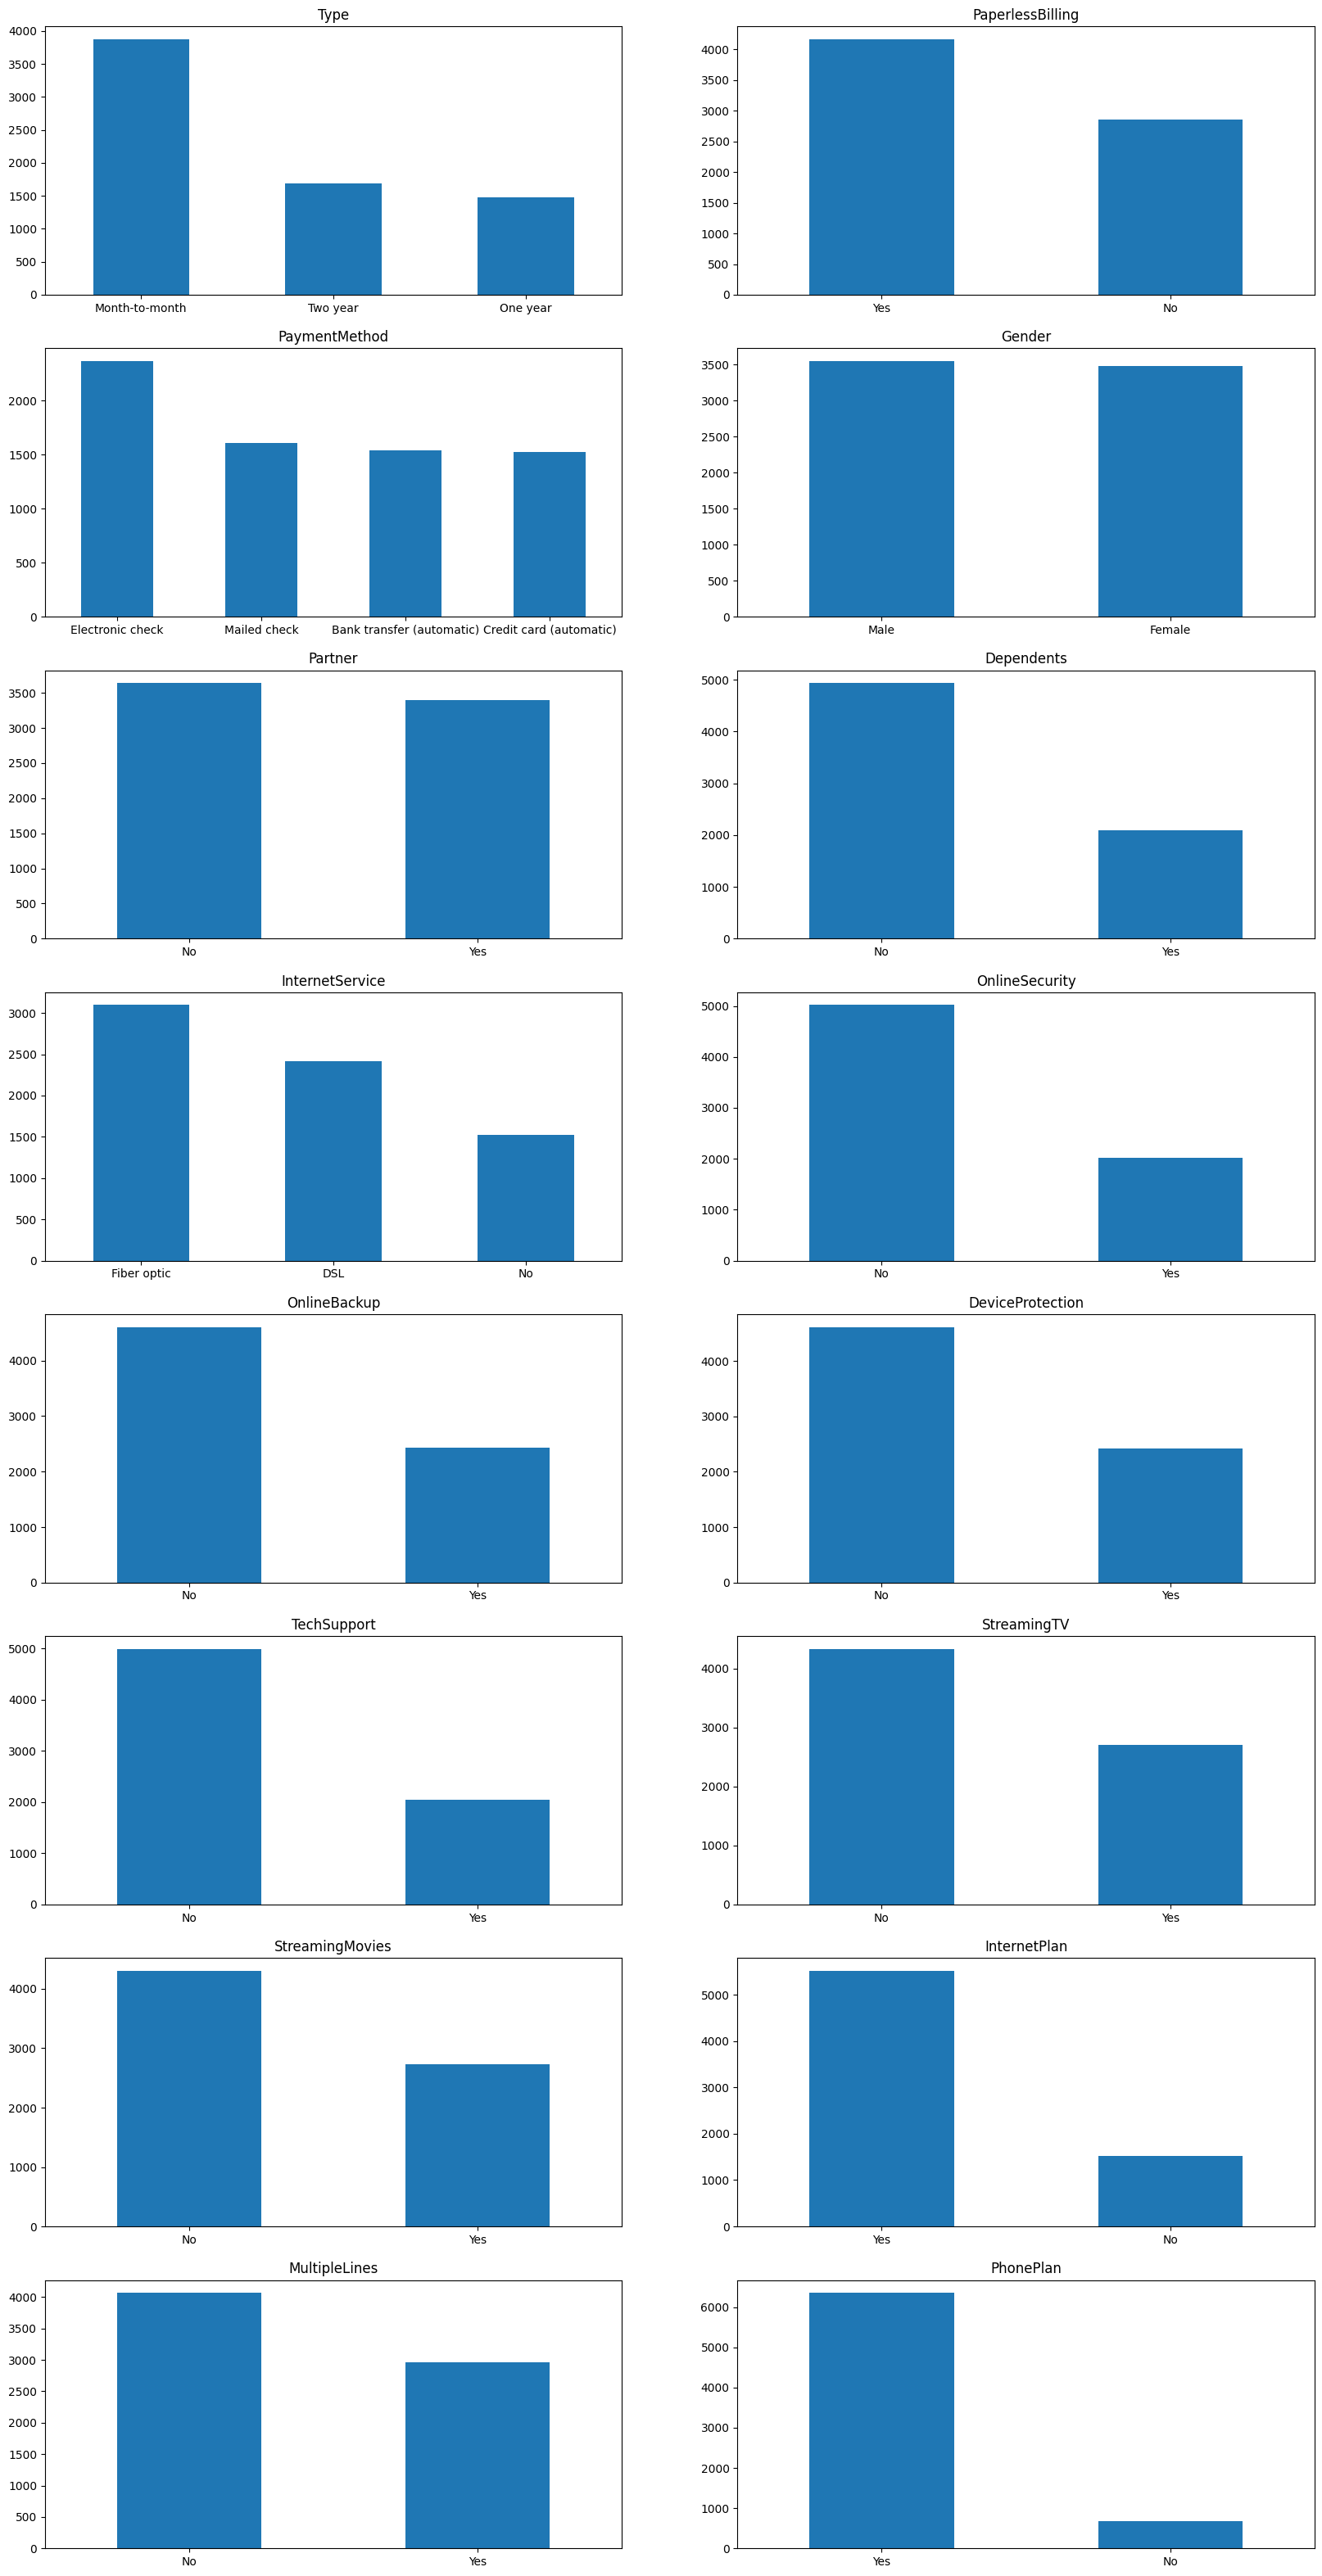

In [20]:
plt.figure(figsize=(20, 40))

for idx, column in enumerate(categorical):
    ax = plt.subplot(8, 2, idx + 1)
    df[column].value_counts().plot(kind='bar', 
                                   title=column, 
                                   ax=ax,
                                   rot=0)
        
plt.show()

В части категориальных признаков можем отметить следующие особенности:
* Среди типов оплаты преобладает ежемесячный тарифный план
* Соотношение в PaperlessBilling может указывать на то, что большая доля пользователей предпочитает получать бумажные квитанции, что косвенно указывает на, то что значительную долю пользователей составляет старшая возрастная группа. 
* Также в части дополнительных сервисов интернет тарифов, преобладает отказ от дополнительных опций, то есть большая часть клиентов старается минимизировать траты. 
* Отдельно необходимо выделить признаки StreamingTV и StreamingMovies больше половины пользователей интернета пользуются IP TV вероятнее всего  этим фактором обусловлены горбы на гистограмме MonthlyCharges, то есть это 2 категории пользователей интернет контратов - с подключенным IP TV и без него. 
* Гендерное соотношение пользователей и Семейный статус находятся примерно на одном уровне. 


### Выводы по блоку 2:

Мы проанализировали числовые и категориальные признаки и описали наблюдения.

Данные не нуждаются в удалении выбросов и аномальных значений, можем переходить к следуюещй части проекта. 

In [21]:
df[['MonthlyCharges', 'TotalCharges', 'Churn', 'DaysUsed']].corr()

,MonthlyCharges,TotalCharges,Churn,DaysUsed
MonthlyCharges,1.000000,0.651065,0.192858,0.246715
TotalCharges,0.651065,1.000000,-0.199484,0.825811
Churn,0.192858,-0.199484,1.000000,-0.354496
DaysUsed,0.246715,0.825811,-0.354496,1.000000


Можем заметить, что присутствует мультиколлинеарность признаков TotalCharges и DaysUsed - удалим TotalCharges 

In [22]:
df.drop('TotalCharges', axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7032 non-null   object 
 1   PaperlessBilling  7032 non-null   object 
 2   PaymentMethod     7032 non-null   object 
 3   MonthlyCharges    7032 non-null   float64
 4   Churn             7032 non-null   int64  
 5   DaysUsed          7032 non-null   int64  
 6   Gender            7032 non-null   object 
 7   SeniorCitizen     7032 non-null   int64  
 8   Partner           7032 non-null   object 
 9   Dependents        7032 non-null   object 
 10  InternetService   7032 non-null   object 
 11  OnlineSecurity    7032 non-null   object 
 12  OnlineBackup      7032 non-null   object 
 13  DeviceProtection  7032 non-null   object 
 14  TechSupport       7032 non-null   object 
 15  StreamingTV       7032 non-null   object 
 16  StreamingMovies   7032 non-null 

Разделим данные на обучающую и тестовую выборки, по требованию заказчика тестовая выборка должна составлять 25% 

In [23]:
train, test = train_test_split(df, test_size=0.25, random_state=RANDOM_STATE)

Выделим фичи и целевой признак

In [24]:
X = train.drop(['Churn'], axis=1)
y = train['Churn']
X_test = test.drop(['Churn'],axis=1)
y_test = test['Churn']

print('Размер обучающей выборки: {} объектов, {} признаков'.format(X.shape[0], X.shape[1]))
print('Размер тестовой выборки: {} объектов, {} признаков'.format(X_test.shape[0], X_test.shape[1]))

Размер обучающей выборки: 5274 объектов, 19 признаков
Размер тестовой выборки: 1758 объектов, 19 признаков


Для дальнейшего удобства использования выделим категориальные и числовые признаки

In [25]:
categorical= ['Type', 'PaperlessBilling', 'PaymentMethod', 'Gender', 'Partner',
              'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
              'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
              'InternetPlan', 'MultipleLines', 'PhonePlan','SeniorCitizen']
              
numerical = ['MonthlyCharges', 'DaysUsed']

In [26]:
#Установим последнюю версию scikit чтобы избежать ошибок при запуске на разных платформах
# !pip install scikit-learn==1.1.2

Так как мы решаем задачу бинарной классификации мы выбрали следующием модели для сравнения:
* LogisticRegression
* RandomForestClassifier
* CatBoostClassifier

Для определения оптимальной модели используем GridsearcCV с применением пайплайна, в пайплайне применим ColumnTransformer:
* числовых признаков используем StandardScaler
* для категориальных - OneHotEncoder 

Ввиду особенностей CatBoostClassifier, у которого есть встроенные методы работы с категориальными признаками cat_features=categorical (в препроцессоре для Catboost пропустим шаг обработки категориальных переменных), создадим отдельные пайпалайны для каждой модели и перебирем их циклом в GridsearcCV. 

Наиболее оптимальную модель выберем по результатам кроссвалидации KFold(n_splits=5) по величине метрике ROC AUC. 

In [27]:
# Создадим препроцессор для пайпалайна
numeric_transformer = StandardScaler()

categorical_transformer_ohe = OneHotEncoder(handle_unknown='infrequent_if_exist', drop = 'first')

preprocessor = ColumnTransformer(
                                 transformers=[
                                                ("num", numeric_transformer, numerical),
                                                ("cat", categorical_transformer_ohe, categorical),
                                               ]
                                )

In [28]:
RANDOM_STATE = 270223
SCORING = 'roc_auc'


cv = KFold(n_splits=5, shuffle=True)

# пайпалайн для модели LogisticRegression
pipeline1 = Pipeline((
    ('preprocessor', preprocessor),
    ('LogisticRegression', LogisticRegression(random_state=RANDOM_STATE)),
    ))

# пайпалайн для модели RandomForestClassifier
pipeline2 = Pipeline((
    ('preprocessor', preprocessor),
    ('RandomForestClassifier', RandomForestClassifier(random_state=RANDOM_STATE)),
    ))

# пайпалайн для модели CatBoostClassifier
pipeline3 = Pipeline((
    ('CatBoost', CatBoostClassifier(cat_features=categorical, random_state=RANDOM_STATE)),
    ))

# параметры для модели LogisticRegression
param1 = {}
param1['LogisticRegression__solver'] = ['lbfgs']
param1['LogisticRegression__n_jobs'] = [-1]

# параметры для модели RandomForestClassifier
param2 = {}
param2['RandomForestClassifier__max_depth'] = [5, 10, 20]
param2['RandomForestClassifier__min_samples_split'] = [2, 10]
param2['RandomForestClassifier__min_samples_leaf'] = [2, 10]
param2['RandomForestClassifier__n_estimators'] = [10, 50, 100]

# параметры для модели CatBoostClassifier
param3 = {}
param3['CatBoost__depth'] =  [3, 5]
param3['CatBoost__iterations'] =  [500]
param3['CatBoost__learning_rate'] = [0.1, 0.5]
param3['CatBoost__thread_count']  = [-1]
param3['CatBoost__l2_leaf_reg']  = [4, 5]
param3['CatBoost__silent'] = [True]

pars = [param1, param2, param3]
pips = [pipeline1, pipeline2, pipeline3]

# в цикле переберем и выведем олучшие параметры для трех моделей
for i in range(len(pars)):
    gs = GridSearchCV(pips[i], pars[i], n_jobs=-1,cv = cv, scoring=SCORING)
    gs = gs.fit(X, y)
    print(f'Лучшие параметры GridSearch модели №{i+1}:')
    display(gs.best_params_)
    print('Лучший ROC-AUC Score train:', gs.best_score_.round(4))
    print('')
    print('< < ==================================================================== > >')
    print('')

Лучшие параметры GridSearch модели №1:


{'LogisticRegression__n_jobs': -1, 'LogisticRegression__solver': 'lbfgs'}

Лучший ROC-AUC Score train: 0.8424

< < ==================================================================== > >

Лучшие параметры GridSearch модели №2:


{'RandomForestClassifier__max_depth': 10,
 'RandomForestClassifier__min_samples_leaf': 10,
 'RandomForestClassifier__min_samples_split': 2,
 'RandomForestClassifier__n_estimators': 100}

Лучший ROC-AUC Score train: 0.857

< < ==================================================================== > >

Лучшие параметры GridSearch модели №3:


{'CatBoost__depth': 3,
 'CatBoost__iterations': 500,
 'CatBoost__l2_leaf_reg': 4,
 'CatBoost__learning_rate': 0.5,
 'CatBoost__silent': True,
 'CatBoost__thread_count': -1}

Лучший ROC-AUC Score train: 0.923

< < ==================================================================== > >



По результатам GridSearchCV мы получили следующием метрики ROC-AUC на обучающей выборке:
* LogisticRegression - 0.8447
* RandomForestClassifier - 0.8589
* CatBoostClassifier - 0.9228

Для валидации модели на тестовой выборке выбреме CatBoostClassifier со следующими параметрами 

* depth = 3
* iterations = 500
* l2_leaf_reg = 4
* learning_rate = 0.5
* thread_count = -1

далее чтобы не запускать весь код снова используем параметр GridSearchCV best_estimator_ для расчета ROC-AUC на тестовой выборке и построения графика важности признаков

ROC-AUC Test Score 0.9446


,importances
DaysUsed,64.692677
MonthlyCharges,9.868124
InternetPlan,6.361715
Type,4.770230
InternetService,3.918213


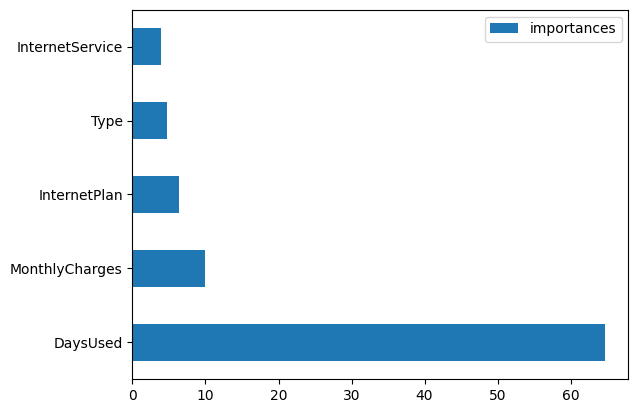

In [29]:
#посчитаем предсказания модели на тестовой выборке
predicted_model = gs.best_estimator_.predict_proba(X_test)[:, 1]

feature_importances = pd.DataFrame(gs.best_estimator_[0].feature_importances_, index = X.columns, columns=['importances'])
feature_importances = feature_importances.sort_values(by='importances', ascending=False)

#рассчитаем ROC-AUC для тестовой выборки
print('ROC-AUC Test Score', roc_auc_score(y_test, predicted_model).round(4))
display(feature_importances.head())
feature_importances.head().plot(kind='barh');

Результат метрики на тестовой выборке **0.9446 что выше обозначенного заказчиком порогового значения**. 

Наибольшее влияние на результат расчета модели оказал выделенный нами признак DaysUsed. 

Рассчитаем ROC-AUC на тестовой выборке для CatBoostClassifier и построим визуализацию важности признаков



Также по требованию заказчика необходимо построить ROC-кривую и матрицу ошибок

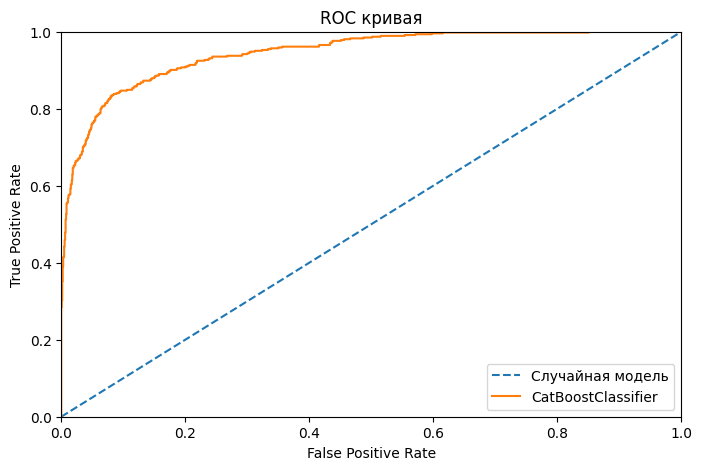

In [30]:
#построим ROC-AUC Curve
plt.figure(figsize=[8,5])

plt.plot([0, 1], [0, 1], linestyle='--', label='Случайная модель')

fpr, tpr, thresholds = roc_curve(y_test, predicted_model)
plt.plot(fpr, tpr, label='CatBoostClassifier')

plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right', fontsize='medium')
plt.title("ROC кривая")
plt.show()

/Users/andrew/Documents/Python_projects/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


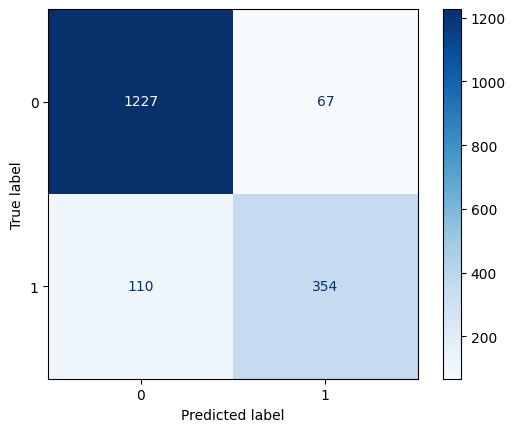

              precision    recall  f1-score   support

           0       0.92      0.95      0.93      1294
           1       0.84      0.76      0.80       464

    accuracy                           0.90      1758
   macro avg       0.88      0.86      0.87      1758
weighted avg       0.90      0.90      0.90      1758



In [31]:
# построим confusion_matrix и выведем classification_report
cm =confusion_matrix(y_test, predicted_model.round())
matrix = plot_confusion_matrix(gs, X_test, y_test, cmap=plt.cm.Blues)
plt.show();
print(classification_report(y_test, predicted_model.round()))

### 4. Итоговые выводы по проекту

Для анализа нам были предоставлены заказчиком 4 датасета: 
- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Мы проанализировали предоставленные данные и выделили **следующие особенности**: 
* Все четыре датасета не содержали пропущенных значений. 
* В датасетах contract и personal **7043** записей, в internet и phone - **5517 и 6361** соотвтетственно.
* целевой признак явным образом выделен не был. 

В ходе предобработки данных мы **выделили целевой признак Churn** и **дополнительный признак DaysUsed** (общее количество дней пользования контратком) на основе дат начала и окончания пользования услугами. Также выделили **признаки наличия контракта на пользование Телефоном и Интернетом**. 

В третьей части построения моделей мы выбрали 3х кандидатов для решения задачи бинарной классификации, которые показали следующие **результаты метрики AUC ROC на обучающей выборке**:
* LogisticRegression - 0.8447
* RandomForestClassifier - 0.8589 
* CatBoostClassifier - 0.9228 

Для моделирования мы использовали стэк: **Pipeline (ColumnTransformer: StandardScaler + OneHotEncoder) + GridsearcCV (KFold)**

Мы протестировали CatBoostClassifier на тестовой выборке и получили результат метрики **AUC ROC - 0.9446** что выше обозначенного заказчиком порогового значения. 

Наибольшее влияние на результат расчета модели оказал выделенный нами признак DaysUsed. 

Цель проекта достигнута. 

# Отчет по проекту

В соответствии с утвержденным планом работ были выделены три ключевых этапа: **подготовка данных**, **исследовательский анализ данных (EDA)** и этап **построения моделей**.
**Все этапы плана работ были выполнены и поставленные задачи достигнуты.**

Из основных трудностей при реализации проекта можно выделить **подготовку данных** и **выделение целевого признака**, а также **реализацию перебора моделей в едином цикле** с записью параметров лучшей модели в GridsearchCV.

В части подготовки данных мы **проанализировали состав четырех исходных датасетов и выделили ключевые особенности**, а также **выделили** на основе нескольких признаков **целевой признак**.

- На основе признаков BeginDate и EndDate выделили новый признак DaysUsed который отражал общее количество дней пользования контрактом.
- Также на основании признака EndDate выделили целевой признак Churn - если указана дата окончания контракта, то целевой признак = 1, в обратном случае - 0.
- Чтобы не потерять важные данные при объединении датасетов, мы добавили в таблицы internet и phone соответствующие признаки.
- Так как наша задача не была связана с прогнозированием временных рядов, мы удалили признаки BeginDate и EndDate, после проведения вышеуказанных манипуляций с ними, чтобы не сбивать с толку модель.
- Избавились от мультиколлинеарности признаков TotalCharges и DaysUsed - удалив TotalCharges. 
- После объединения датасетов появились пропуски, так как в исходных датасетах было разное количество записей, это обусловлено тем, что контракты на телефон и интернет заключаются поотдельности, заполнили пропуски значениями "No" .
      
Для реализации перебора моделей в GridsearchCV мы **использовали модицифировнный пайплайн** в котором **для каждой выбранной модели** прописали **уникальную предобработку данных**, после чего в цикле подставили значения в GridsearchCV и обучили модели. 

**Основной особенностью данного подхода является, то, что нам не нужно было запускать и обучать каждую модель по отдельности, а потом вручную сравнивать метрики качества, мы просто вывели best_score_ и best_param_ для каждой модели и в последующем для проверки модели на Тестовой выборке использовали model.best_estimator_.predict_proba(X_test)** 

Для моделирования мы использовали следующий стэк **Pipeline (ColumnTransformer: StandardScaler + OneHotEncoder) + GridsearcCV (KFold)**
- Так как мы решаем задачу бинарной классификации мы выбрали следующием модели для сравнения: LogisticRegression, RandomForestClassifier, CatBoostClassifier
- Для определения оптимальной модели используем GridsearcCV с применением пайплайна, в пайплайне применим ColumnTransformer: числовых признаков используем StandardScaler, для категориальных - OneHotEncoder 
- Ввиду особенностей CatBoostClassifier, у которого есть **встроенные методы работы с категориальными признаками** cat_features=categorical (в препроцессоре для Catboost мы пропустили шаг обработки категориальных переменных), создали **отдельные пайпалайны для каждой модели** и перебирали их циклом в GridsearcCV. 
- Наиболее оптимальную модель мы выбрали по результатам кроссвалидации **KFold(n_splits=5)** по величине метрике **ROC AUC**. 

На вход модели мы подавали датасет состоящий из следующих признаков: 

Type, PaperlessBilling, PaymentMethod, MonthlyCharges, DaysUsed, Gender, SeniorCitizen, Partner, Dependents, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection,
TechSupport, StreamingTV, StreamingMovies, InternetPlan, MultipleLines, PhonePlan

На обучающей выборке по трем моделям мы получили следующие результаты метрики ROC AUC: 
* LogisticRegression - **0.8447**
* RandomForestClassifier - **0.8589**
* CatBoostClassifier - **0.9228** 

Наилучшее качество на обучающей выборке показала модель **CatBoostClassifier со следующими гиперпараметрами**:
* depth = 3
* iterations = 500
* l2_leaf_reg = 4
* learning_rate = 0.5
* thread_count = -1

После запуска модели **на тестовой выборке** с выбранными гиперпараметрами метрика качества **AUC ROC увеличилась** и составила  **0.9446** что выше обозначенного заказчиком порогового значения. 

**Наибольшее влияние** на результат расчета модели **оказал** выделенный нами **новый признак**, которого не было в исходном датасете - **DaysUsed**. 

**Цель проекта достигнута.**
